# CAPSTONE PROJECT : BATTLE OF THE NEIGHBOURHOODS

## Applied Data Science Capstone by IBM/Coursera
### Table of contents
#### 1. Introduction: Business Problem
#### 2. Data
#### 3. Methodology
#### 4. Analysis
#### 5. Results and Discussion
#### 6. Conclusion

## 1. Introduction: Business Problem
##### In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening a restaurant in Toronto.

##### Since there are lots of restaurant in  Toronto, we will try to detect locations that are not already crowded with restaurants. We are also particularly interested in areas with no restaurants in the vicinity.

##### We will use our data science knowledge to find out most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## 2. Data 
#####  We will need geo-locational information about that specific borough and the neighborhoods in that borough. We need to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes. 
##### Now that when we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.  Here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data
#####  We will need data about different venues in different neighborhoods of that specific borough. In order to gain that information we will use "Foursquare api" locational information. 

## 3. Methodology
##### In this project we will try to identify areas of Toronto that have low restaurant density. 

##### In first step we have collected the required data: location and type (category) of every restaurant. We have also identified restaurant (according to Foursquare categorization).

##### Second step in our analysis will be exploration of ‘restaurant density’ across different areas of Toronto to identify a few promising areas close to center with low number of restaurant in general (and less restaurant in vicinity) and focus our attention on those areas.

##### In last step we will focus on most promising areas and within those created clusters of locations that meet some basic requirements established in discussion with stakeholders. We will present map of all such locations but also create clusters (using k-means clustering) of those locations to identify neighborhoods which should be a starting point for final exploration and search for optimal venue location by stakeholders.

## Analysis
##### Let’s perform some basic explanatory data analysis and derive some additional info from our raw data. Let's start by importing important libraries first.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering

# to save and load python obj
import pickle

In [3]:
### scrape toronto data from wikepedia page
Toronto_df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", header=0)[0]
Toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
### read csv file that has the geographical coordinates of each postal code downloaded from: http://cocl.us/Geospatial_data
Geospatial_Coordinates_df = pd.read_csv("Geospatial_Coordinates.csv")
Geospatial_Coordinates_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
# change name of columns to make data consistent of Toronto_df
Toronto_df.rename(columns={'Postcode': 'PostalCode'}, inplace=True)
Toronto_df.head(1)

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned


In [6]:
# change name of columns to make data consistent of Geospatial_Coordinates_df
Geospatial_Coordinates_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
Geospatial_Coordinates_df.head(1)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353


In [8]:
### perform some data cleaning
Toronto_df = Toronto_df[Toronto_df.Borough != 'Not assigned']

Toronto_df = Toronto_df.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

Toronto_df.loc[Toronto_df['Neighbourhood'] =='Not assigned' , 'Neighbourhood'] = Toronto_df['Borough']

Toronto_df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
print(Toronto_df.shape)
print(Geospatial_Coordinates_df.shape)

(103, 3)
(103, 3)


In [10]:
# merge postal code data with geospatial coordinates
Toronto_Loc_df = pd.merge(Toronto_df, Geospatial_Coordinates_df, how='left', on=['PostalCode'])
Toronto_Loc_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
Toronto_Loc_df.shape

(103, 5)

In [12]:
#Use geopy library to get the latitude and longitude values of Toronto.
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [13]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)

# add markers to map
for lat, lng, Borough, Neighbourhood in zip(Toronto_Loc_df['Latitude'], Toronto_Loc_df['Longitude'], Toronto_Loc_df['Borough'], Toronto_Loc_df['Neighbourhood']):
    label = '{}, {}'.format(Neighbourhood, Borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [ ]:
### Define Foursquare Credentials and Version
CLIENT_ID = '@hidden- Client ID' # your Foursquare ID
CLIENT_SECRET = '@hidden- Client Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [15]:
### explore neighbourhoods in toronto
# defining radius and limit of venues to get
radius=500
LIMIT=100

In [16]:
#Let's create a function to repeat the same process to all the neighborhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
toronto_venues = getNearbyVenues(names=Toronto_Loc_df['Neighbourhood'],
                                   latitudes=Toronto_Loc_df['Latitude'],
                                   longitudes=Toronto_Loc_df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [37]:
# used pickle to save and load python obj
def save_obj(obj,filename):
    # Store data (serialize)
    with open(filename+'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    # Load data (deserialize)
    with open(filename+'.pickle', 'rb') as handle:
        unserialized_data = pickle.load(handle)
    return unserialized_data

In [38]:
save_obj(toronto_venues,'toronto_venues')
toronto_venues1 = load_obj('toronto_venues')

In [42]:
# check size of resulting dataframe
print(toronto_venues1.shape)
toronto_venues1.head(10)

(2270, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
5,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
6,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
7,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection
8,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Eggsmart,43.767800,-79.190466,Breakfast Spot
9,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop


In [43]:
# check how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues1['Venue Category'].unique())))

There are 273 uniques categories.


In [44]:
# Check out what are those unique venues
toronto_venues1['Venue Category'].unique()

array(['Fast Food Restaurant', 'Bar', 'Pizza Place', 'Electronics Store',
       'Mexican Restaurant', 'Rental Car Location', 'Medical Center',
       'Intersection', 'Breakfast Spot', 'Coffee Shop',
       'Korean Restaurant', 'Soccer Field', 'Hakka Restaurant',
       'Caribbean Restaurant', 'Thai Restaurant', 'Athletics & Sports',
       'Bank', 'Bakery', 'Fried Chicken Joint', 'Playground',
       'Smoke Shop', 'Department Store', 'Convenience Store',
       'Discount Store', 'Bus Station', 'Bus Line', 'Metro Station',
       'Park', 'Motel', 'American Restaurant', 'Café',
       'General Entertainment', 'Skating Rink', 'College Stadium',
       'Indian Restaurant', 'Chinese Restaurant',
       'Latin American Restaurant', 'Pet Store', 'Vietnamese Restaurant',
       'Light Rail Station', 'Furniture / Home Store', 'Sandwich Place',
       'Middle Eastern Restaurant', 'Shopping Mall', 'Auto Garage',
       'Accessories Store', 'Lounge', 'Italian Restaurant',
       'Noodle House', '

### filter out only those venues which have restaurant in it

In [45]:
toronto_venues1 = toronto_venues1[toronto_venues1['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
print(toronto_venues1.shape)
toronto_venues1.head()

(523, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
2,Woburn,43.770992,-79.216917,Korean Grill House,43.770812,-79.214502,Korean Restaurant
3,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant
4,Cedarbrae,43.773136,-79.239476,Drupati's Roti & Doubles,43.775222,-79.241678,Caribbean Restaurant


In [47]:
### Analysing Each Neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues1[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues1['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot.head()

,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Rouge, Malvern"
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Guildwood, Morningside, West Hill"
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Woburn
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cedarbrae
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cedarbrae


In [48]:
# check new dataframe size
toronto_onehot.shape

(523, 54)

In [49]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Adelaide, King, Richmond",0.000000,0.115385,0.076923,0.000000,0.038462,0.000000,0.000000,0.000000,0.038462,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.038462,0.000000,0.000000,0.038462,0.000000,0.038462,0.038462,0.00,0.00,0.038462,0.00,0.038462,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.115385,0.038462,0.00,0.076923,0.000000,0.00,0.115385,0.000000,0.076923,0.000000
1,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.200000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
4,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
5,"Bedford Park, Lawrence Manor East",0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.181818,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.00,0.090909,0.000000,0.00,0.181818,0.000000,0.000000,0.000000
6,Be

In [50]:
# check new dataframe size 
toronto_grouped.shape

(70, 54)

In [51]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0  American Restaurant  0.12
1      Thai Restaurant  0.12
2           Restaurant  0.12
3     Sushi Restaurant  0.08
4     Asian Restaurant  0.08


----Agincourt----
                venue  freq
0  Chinese Restaurant   1.0
1   Afghan Restaurant   0.0
2   Polish Restaurant   0.0
3   Jewish Restaurant   0.0
4   Korean Restaurant   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0  Fast Food Restaurant   1.0
1     Afghan Restaurant   0.0
2    Persian Restaurant   0.0
3     Jewish Restaurant   0.0
4     Korean Restaurant   0.0


----Bathurst Manor, Downsview North, Wilson Heights----
                       venue  freq
0         Chinese Restaurant   0.2
1           Sushi Restaurant   0.2
2  Middle Eastern Restaurant   0.2
3                 Restaurant   0.2
4       Fast Food Restaurant   0.2


----Bayview Village----
           

                venue  freq
0  Mexican Restaurant   0.4
1          Restaurant   0.4
2   French Restaurant   0.2
3   Afghan Restaurant   0.0
4  Persian Restaurant   0.0


----High Park, The Junction South----
                       venue  freq
0         Mexican Restaurant  0.33
1         Italian Restaurant  0.17
2            Thai Restaurant  0.17
3  Cajun / Creole Restaurant  0.17
4       Fast Food Restaurant  0.17


----Hillcrest Village----
                      venue  freq
0  Mediterranean Restaurant   0.5
1      Fast Food Restaurant   0.5
2         Afghan Restaurant   0.0
3        Persian Restaurant   0.0
4         Jewish Restaurant   0.0


----Humber Bay Shores, Mimico South, New Toronto----
                     venue  freq
0      American Restaurant  0.25
1       Seafood Restaurant  0.25
2               Restaurant  0.25
3     Fast Food Restaurant  0.25
4  New American Restaurant  0.00


----Humber Summit----
                 venue  freq
0  Empanada Restaurant   1.0
1    Afghan Res

In [52]:
### put that into a pandas dataframe

#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
# create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Restaurant,American Restaurant,Thai Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Mediterranean Restaurant,Indian Restaurant,New American Restaurant,Colombian Restaurant
1,Agincourt,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,"Bathurst Manor, Downsview North, Wilson Heights",Sushi Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant
4,Bayview Village,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant


### Find out optimal value of k(number of clusters)

Using elbow method - where curve bends we consider it as optimal k(number of clusters).

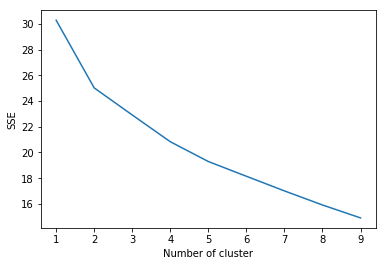

In [56]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(toronto_grouped_clustering)
    toronto_grouped_clustering["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [57]:
### Cluster Neighborhoods

# Run k-means to cluster the neighborhood into 2 clusters.

# set number of clusters
kclusters = 2

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [58]:
#create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
Toronto_Loc_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Toronto_Loc_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Mexican Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Korean Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant


In [60]:
print(toronto_merged.shape)
toronto_merged.isna().sum()

(103, 16)


PostalCode                 0
Borough                    0
Neighbourhood              0
Latitude                   0
Longitude                  0
Cluster Labels            33
1st Most Common Venue     33
2nd Most Common Venue     33
3rd Most Common Venue     33
4th Most Common Venue     33
5th Most Common Venue     33
6th Most Common Venue     33
7th Most Common Venue     33
8th Most Common Venue     33
9th Most Common Venue     33
10th Most Common Venue    33
dtype: int64

In [61]:
toronto_merged.dropna(inplace=True) 
print(toronto_merged.shape)
toronto_merged.isna().sum()

(70, 16)


PostalCode                0
Borough                   0
Neighbourhood             0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

In [62]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Mexican Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Korean Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [63]:
### Finally, let's visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

In [64]:
# cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,0,Mexican Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
3,Scarborough,0,Korean Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
4,Scarborough,0,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
8,Scarborough,0,American Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
10,Scarborough,0,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Eastern European Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant
11,Scarborough,0,Middle Eastern Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
12,Scarborough,0,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
13,Scarborough,0,Italian Restaurant,Thai Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant
19,North York,0,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
22,North York,0,Ramen Restaurant,Restaurant,Japanese Restaurant,Sushi Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Indonesian Restaurant,Seafood Restaurant,Gluten-free Restaurant


In [65]:
# cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
7,Scarborough,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
15,Scarborough,1,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
17,North York,1,Fast Food Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
18,North York,1,Fast Food Restaurant,Asian Restaurant,Japanese Restaurant,American Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Greek Restaurant,Gluten-free Restaurant
35,East York,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
74,York,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
87,East Toronto,1,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
92,Etobicoke,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
101,Etobicoke,1,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant


## Results
##### Our analysis shows that although there is a great number of restaurants in Toronto , there are pockets of low restaurant density far from Toronto Center. Highest concentration of restaurants was detected near Toronto Center(Downtown Toronto), so we focused our attention to areas far away from Toronto Center, corresponding to boroughs near by.

## Discussion
##### Based on result of all this East Toronto, East York, Etobicoke can be the potential new restaurant locations based on number of existing venues. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas in Toronto but not crowded with existing restaurant - it is entirely possible that there is a very good reason for small number of restaurant in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.


## Conclusion
##### Purpose of this project was to identify Toronto areas close to center with low number of restaurant in order to aid stakeholders in narrowing down the search for optimal location for a new restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis , and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurant. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

##### Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.